# Preparation

### Imports

In [ ]:
using NBInclude;
@nbinclude("Rosenbrock_BFGS.ipynb");
@nbinclude("Rosenbrock_GD_Newton.ipynb");
@nbinclude("Visualization.ipynb")

using BenchmarkTools
using StatPlots
using Gadfly

import Cairo, Fontconfig

# Mean performance of 100 runs - preparation

### Constants

In [2]:
SAMPLES = 100;
ITERS = 10000;
ERROR = 10e-6;
rate = 0.001953125; #GradientDescent
m = 4; #L-BFGS

### Variables

In [3]:
mean_iters = zeros(8);
mean_error = zeros(8);
mean_exec_time = zeros(8);
mean_alloc_bytes = zeros(8);

### Testing mean performance

In [4]:
function rosenbrock_performance(fun, samples, dimensions, max_iters, max_error=0)
    timed_history = []
    for j in 1:samples
        timed = @timed fun(rand(dimensions), max_iters, max_error)
        push!(timed_history, timed)
    end
    
    mean_iters = sum(map(h->h.value[3], timed_history))/samples
    mean_error = sum(map(h->last(h.value[2]), timed_history))/samples
    mean_exec_time = sum(map(h->h.time, timed_history))/samples
    mean_alloc_bytes = sum(map(h->h.bytes, timed_history))/samples
    
    return mean_iters, mean_error, mean_exec_time, mean_alloc_bytes
end

rosenbrock_performance (generic function with 2 methods)

In [5]:
function test_performance(fun, i)
    iters, error, time, bytes = rosenbrock_performance(fun, SAMPLES, DIMENS, ITERS, ERROR)
    mean_iters[i] = iters; mean_error[i] = error; mean_exec_time[i] = time; mean_alloc_bytes[i] = bytes;
    return iters, error, time, bytes
end

test_performance (generic function with 1 method)

### Adapters

In [6]:
gd(x, max_iters, max_error) = rosenbrock_gradient_descent(x, rate, max_iters, max_error)
lbfgs(x, max_iters, max_error) = rosenbrock_LBFGS(x, m, max_iters, max_error)

lbfgs (generic function with 1 method)

# Mean performance of 100 runs for 2 dimens

In [7]:
DIMENS = 2;

### Gradient Descent performance

In [8]:
test_performance(gd, 1)

(5338.36, 9.992404128893095e-6, 0.007684691339999999, 4.502912e6)

### Newton's Method performance

In [9]:
test_performance(rosenbrock_newton, 2)

(4.94, 1.4428148338664077e-6, 0.0012786256099999998, 460466.25)

### BFGS performance

In [10]:
test_performance(rosenbrock_BFGS, 3)

(10.15, 1.9778140804806715e-6, 0.00089921719, 502946.68)

### L-BFGS performance

In [11]:
test_performance(lbfgs, 4)

(10.3, 2.4410673151550006e-6, 0.0009549189000000001, 518100.59)

# Mean performance of 100 runs for 4 dimens

In [12]:
DIMENS = 4;

### Gradient Descent performance

In [13]:
test_performance(gd, 5)

(10000.0, 1.7646792363069883, 0.01098441787, 1.159216e7)

### Newton's Method performance

In [14]:
test_performance(rosenbrock_newton, 6)

(1511.33, 1.7953598556464717e6, 0.009077720769999999, 1.077273344e7)

### BFGS performance

In [15]:
test_performance(rosenbrock_BFGS, 7)

(20.41, 2.4045792449910844e-6, 0.0006038790300000001, 907659.52)

### L-BFGS performance

In [16]:
test_performance(lbfgs, 8)

(23.86, 3.1868303308904593e-6, 0.00100158095, 1.06667696e6)

# Mean performance of 100 runs - visualization

In [17]:
set_default_plot_size(18cm, 13cm)

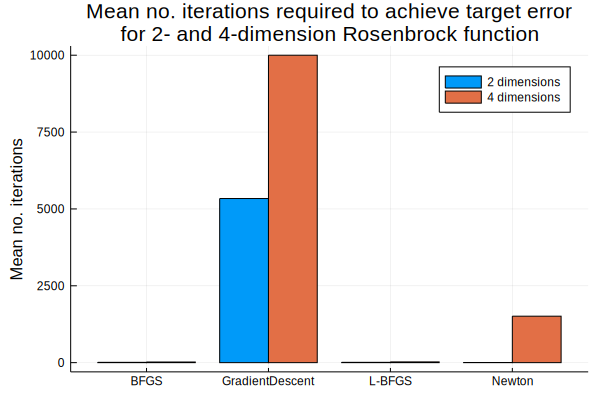

In [18]:
plt = groupedbar(
    repeat(["GradientDescent", "Newton", "BFGS", "L-BFGS"], outer=2), 
    mean_iters,
    group=repeat(["2 dimensions", "4 dimensions"], inner = 4),
    ylabel="Mean no. iterations",
    title="Mean no. iterations required to achieve target error \nfor 2- and 4-dimension Rosenbrock function",
)
savefig(plt, "plots/iterations.pdf")
plt

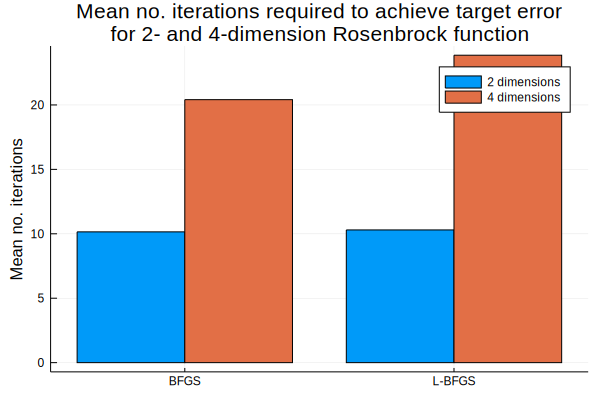

In [19]:
plt = groupedbar(
    repeat(["BFGS", "L-BFGS"], outer=2), 
    [mean_iters[i] for i in [3, 4, 7, 8]],
    group=repeat(["2 dimensions", "4 dimensions"], inner = 2),
    ylabel="Mean no. iterations",
    title="Mean no. iterations required to achieve target error \nfor 2- and 4-dimension Rosenbrock function",
)
savefig(plt, "plots/iterations_bfgs.pdf")
plt

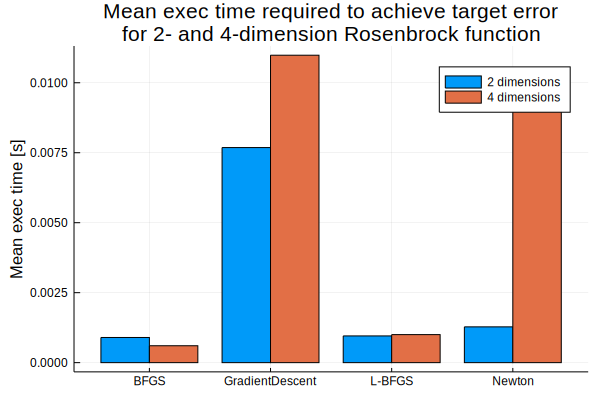

In [20]:
plt = groupedbar(
    repeat(["GradientDescent", "Newton", "BFGS", "L-BFGS"], outer=2), 
    mean_exec_time,
    group=repeat(["2 dimensions", "4 dimensions"], inner = 4),
    ylabel="Mean exec time [s]",
    title="Mean exec time required to achieve target error \nfor 2- and 4-dimension Rosenbrock function",
)
savefig(plt, "plots/time.pdf")
plt

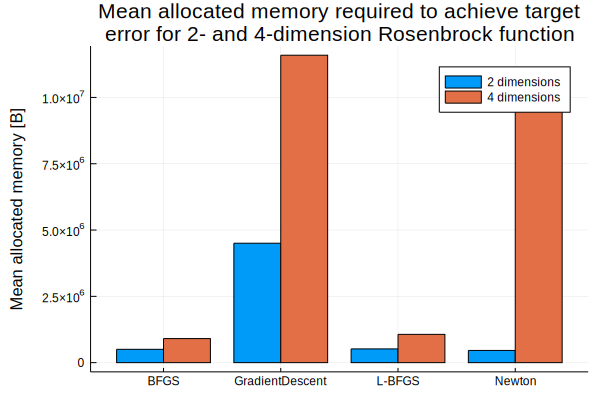

In [21]:
plt = groupedbar(
    repeat(["GradientDescent", "Newton", "BFGS", "L-BFGS"], outer=2), 
    mean_alloc_bytes,
    group=repeat(["2 dimensions", "4 dimensions"], inner = 4),
    ylabel="Mean allocated memory [B]",
    title="Mean allocated memory required to achieve target\nerror for 2- and 4-dimension Rosenbrock function",
)
savefig(plt, "plots/memory.pdf")
plt

# Visualization of Rosenbrock value change - preparation

In [22]:
theme = Theme(
    panel_fill=colorant"gray10",
    default_color=colorant"cyan",
    major_label_color=colorant"black",
    minor_label_color=colorant"black",
    key_label_color=colorant"black",
    key_title_color=colorant"black"
);

# Visualization of Rosenbrock value change for 2 dimens

In [35]:
function contour_cost_multi(
        ax1, ax2, fun, levels, trace1, trace2, trace3, trace4, each, title, xlabel, ylabel )
    set_default_plot_size(18cm, 13cm)    
    plot(
        layer(z = fun, x = ax1, y = ax2, Geom.contour(levels=levels)),
        
        layer( x=trace1[1, 1:each:end], y=trace1[2,1:each:end], Geom.point, Theme(default_color=colorant"lime")),
        layer( x=trace1[1, 1:each:end], y=trace1[2,1:each:end], Geom.line, Theme(default_color=colorant"lime") ),
        
        layer( x=trace2[1, 1:each:end], y=trace2[2,1:each:end], Geom.point, Theme(default_color=colorant"green") ),
        layer( x=trace2[1, 1:each:end], y=trace2[2,1:each:end], Geom.line, Theme(default_color=colorant"green") ),
        
        layer( x=trace3[1, 1:each:end], y=trace3[2,1:each:end], Geom.point, Theme(default_color=colorant"yellow") ),
        layer( x=trace3[1, 1:each:end], y=trace3[2,1:each:end], Geom.line, Theme(default_color=colorant"yellow") ),
        
        layer( x=trace4[1, 1:each:end], y=trace4[2,1:each:end], Geom.point, Theme(default_color=colorant"purple") ),
        layer( x=trace4[1, 1:each:end], y=trace4[2,1:each:end], Geom.line, Theme(default_color=colorant"purple") ),
        
        theme,
        Guide.title(title), Guide.xlabel(xlabel), Guide.ylabel(ylabel),
        Guide.manual_color_key("Legend", ["GradientDescent", "Newton", "BFGS", "L-BFGS"], ["lime", "green", "yellow", "purple"])
    )
end;

In [36]:
DIMENS = 2;
ITERS = 15;

In [40]:
x = rand(DIMENS)
args_gd, values_gd = gd(x, ITERS, ERROR);
args_newton, values_newton = rosenbrock_newton(x, ITERS, ERROR);
args_bfgs, values_bfgs = rosenbrock_BFGS(x, ITERS, ERROR);
args_lbfgs, values_lbfgs = lbfgs(x, ITERS, ERROR);
x

2-element Array{Float64,1}:
 0.43629215256565734
 0.010005610906870022

In [41]:
SPAN = 100; LEFT = 0; RIGHT = 1.5
ax = LinRange( LEFT, RIGHT, SPAN );
levels = [LinRange(0, 100, 20)...];

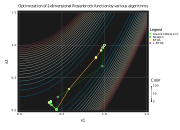

In [42]:
plt = contour_cost_multi(
    ax, ax,
    (x, y) -> rosenbrock( [x, y] ), levels,
    args_gd, args_newton, args_bfgs, args_lbfgs, 1,
    "Optimization of 2-dimensional Rosenbrock function by various algorithms",
    "x1", "x2",
)
draw(PDF("plots/contour_2_multi.pdf"), plt)
plt

In [43]:
test_contour(args, name) = contour_cost(
    ax, ax,
    (x, y) -> rosenbrock( [x, y] ), levels,
    args, 1,
    name,
    "x1", "x2",
)

test_contour (generic function with 1 method)

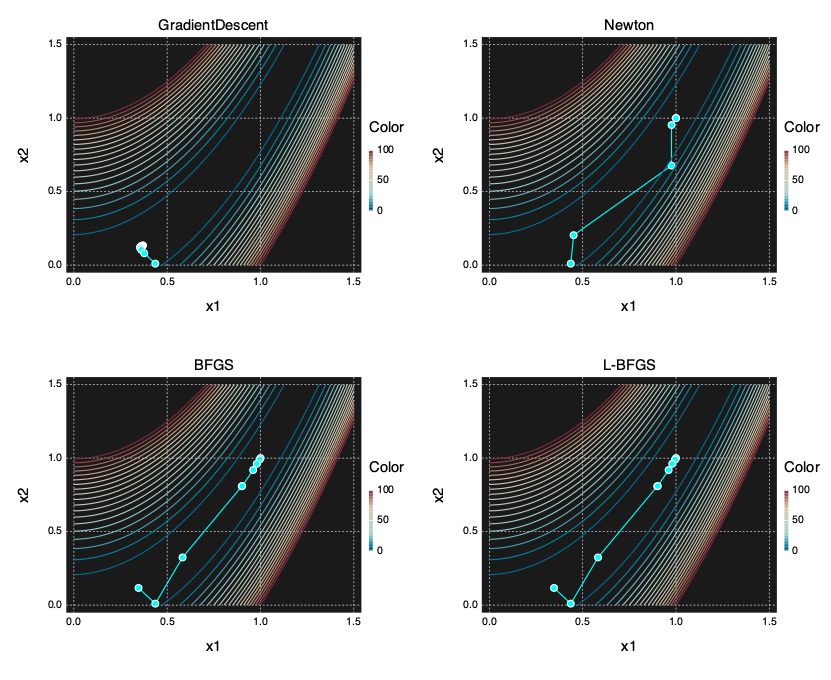

In [44]:
plot_gd = test_contour(args_gd, "GradientDescent")
plot_newton = test_contour(args_newton, "Newton")
plot_bfgs = test_contour(args_bfgs, "BFGS")
plot_lbfgs = test_contour(args_lbfgs, "L-BFGS")
plt = gridstack([plot_gd plot_newton; plot_bfgs plot_lbfgs])
draw(PDF("plots/contour_2_grid.pdf"), plt)
plt

# Visualization of Rosenbrock value change for 4 dimens

In [45]:
function visualize_training_process_multi( iters, y1, y2, y3, y4, title, xlabel, ylabel )
    set_default_plot_size(18cm, 10cm)
    plot(
        layer(x=collect(1:length(y1)), y=y1, Geom.line, Theme(default_color=colorant"lime")),
        layer(x=collect(1:length(y2)), y=y2, Geom.line, Theme(default_color=colorant"green")),
        layer(x=collect(1:length(y3)), y=y3, Geom.line, Theme(default_color=colorant"yellow")),
        layer(x=collect(1:length(y4)), y=y4, Geom.line, Theme(default_color=colorant"purple")),
        theme,
        Guide.title(title), Guide.xlabel(xlabel), Guide.ylabel(ylabel),
        Guide.manual_color_key("Legend", ["GradientDescent", "Newton", "BFGS", "L-BFGS"], ["lime", "green", "yellow", "purple"]),
        Scale.x_log10, Scale.y_log10,
    )
end;

In [46]:
DIMENS = 4;
ITERS = 200;

In [47]:
x = rand(DIMENS)
_, values_gd = gd(x, ITERS, ERROR);
_, values_newton = rosenbrock_newton(x, ITERS, ERROR);
_, values_bfgs = rosenbrock_BFGS(x, ITERS, ERROR);
_, values_lbfgs = lbfgs(x, ITERS, ERROR);
x

4-element Array{Float64,1}:
 0.7463738363015726
 0.10266103347470268
 0.7567498718154841
 0.47886505434090343

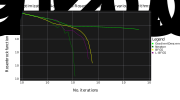

In [48]:
plt = visualize_training_process_multi(ITERS, values_gd, values_newton, values_bfgs, values_lbfgs, 
    "Optimization of 4-dimensional Rosenbrock function by various algorithms",
    "No. iterations", "Rosenbrock function value (y)")
draw(PDF("plots/contour_4_multi.pdf"), plt)
plt